In [1]:
import tensorflow as tf
import numpy as np
from importlib import reload
%load_ext autoreload
%autoreload 2

/Users/ruoxuan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import cs231n.models.cnn
reload(cs231n.models.cnn)
from cs231n.models.cnn import * 

In [107]:
import matplotlib.pyplot as plt

In [3]:
from RLLSTM_anchor import * 

In [169]:
def sample_ix(prob):
    cumprob = np.cumsum(np.array(prob))
    s = np.random.uniform()
    ix = np.argmax(cumprob > s)
    return ix

def sample_ix_anchor(prob):
    prob = [1 - prob, prob]
#     if type(prob) is not list: # this represents anchor probability, so with 1 - prob, no anchor, with prob, has anchor
#         prob = [1 - prob, prob] 
    cumprob = np.cumsum(np.array(prob))
    s = np.random.uniform()
    ix = np.argmax(cumprob > s)
    return ix

def model_reward_generator(num_models, max_num_layers, filter_heights_reward, filter_widths_reward, num_filters_reward,
                           height_probs=None, width_probs=None, num_filters_probs=None, reward_noise=0.1, 
                          anchor_reward=None, anchor_probs=None):
    num_filter_heights, num_filter_widths, num_num_filters =len(filter_heights_reward), len(filter_widths_reward), len(num_filters_reward)
    models = list()
    model_rewards = list()
    if height_probs is None:
        height_probs = [[1/num_filter_heights] * num_filter_heights] * max_num_layers
    if width_probs is None:
        width_probs = [[1/num_filter_widths] * num_filter_widths] * max_num_layers
    if num_filters_probs is None:
        num_filters_probs = [[1/num_num_filters] * num_num_filters] * max_num_layers
    if anchor_reward is not None and anchor_probs is None:
        anchor_probs = [[0.5] * t for t in range(1, max_num_layers)]
        
    if anchor_reward is not None:
        model_anchors = list()
        
    for m in range(num_models):
        model_ixes = list()
        reward = np.random.uniform(low=(1-reward_noise), high=(1+reward_noise))
        for t in range(max_num_layers):
            ixes = [sample_ix(height_probs[t]), sample_ix(width_probs[t]), sample_ix(num_filters_probs[t])]
            reward *= filter_heights_reward[ixes[0]] * filter_widths_reward[ixes[1]] * num_filters_reward[ixes[2]]
            model_ixes.append(ixes)
        if anchor_reward is not None:
            anchors = np.zeros((max_num_layers, max_num_layers), dtype=int)
            for t in range(1, max_num_layers):
                for s in range(t): 
                    anchors[s][t] = sample_ix_anchor(anchor_probs[t-1][s])
                    if anchors[s][t] == 1:
                        reward *= anchor_reward[s][t] #assume anchor_reward is a matrix, such as [[0,0.9], [0,0]]
            model_anchors.append(anchors)
        models.append(model_ixes)
        model_rewards.append(reward)
    
    if anchor_reward is not None:
        return models, model_anchors, model_rewards
    else:
        return models, model_rewards

In [156]:
0.95 ** 6 * 1.2* 1.1

0.9703212956249998

In [235]:
filter_heights_reward = [0.90, 0.925, 0.95]; filter_widths_reward = [0.90, 0.925, 0.95]; num_filters_reward = [0.90, 0.925, 0.95]
anchor_reward = [[0, 1.15], [0, 0]] # this is a max_num_layers by max_num_layers matrix

In [83]:
anchor_reward = [[0, 0.9, 0.8], [0, 0, 0.7], [0, 0, 0]] # if there are three layers 

In [236]:
num_models = 100
max_num_layers = 2

num_filter_heights=3; num_filter_widths=3; num_num_filters = 3; lr = 0.01; l2 = 0.0001;
filter_heights=[1,3,7]; filter_widths=[1,3,7]; num_filters=[16,64,128];

# rl_epochs, cnn_epochs = 2, 1
# save_every = 1

config = Config(num_models=num_models, max_num_layers=max_num_layers, num_filter_heights=num_filter_heights,
                num_filter_widths=num_filter_widths, num_num_filters = num_num_filters, l2=l2, lr=lr, set_anchor_point=True)

# init the reinforcement learning lstm model
rllstm = RLLSTM(config)
sess_rllstm = tf.Session(graph=rllstm.graph)
with rllstm.graph.as_default():
    init = tf.global_variables_initializer()
    saver = tf.train.Saver(var_list=tf.trainable_variables())
sess_rllstm.run(init)

In [237]:
loss_hist = list()
models_probs = dict()
for t in range(max_num_layers):
    models_probs['height_' + str(t)], models_probs['width_' + str(t)], models_probs['nfilter_' + str(t)] = list(), list(), list()
    if t > 0:
        models_probs['anchor' + str(t)] = list()
    
for epoch in range(500):
    if epoch == 0:
        models, model_anchors, model_rewards = model_reward_generator(num_models, max_num_layers, 
                                                       filter_heights_reward, filter_widths_reward, num_filters_reward, 
                                                      anchor_reward=anchor_reward)
    else:
        height_probs = [xs[t][0][0] for t in range(max_num_layers)]
        width_probs = [xs[t][1][0] for t in range(max_num_layers)]
        num_filters_probs = [xs[t][2][0] for t in range(max_num_layers)]
        anchor_probs = [[anchors[t][s][0][0] for s in range(len(anchors[t]))] for t in range(max_num_layers - 1)]
        models, model_anchors, model_rewards = model_reward_generator(num_models, max_num_layers, 
                                                       filter_heights_reward, filter_widths_reward, num_filters_reward,
                                                      height_probs=height_probs, width_probs=width_probs, 
                                                       num_filters_probs=num_filters_probs,
                                                      anchor_reward=anchor_reward, anchor_probs=anchor_probs)
    models_feed_dict = {rllstm.models_placeholder: models, 
                        rllstm.R_placeholder: model_rewards, 
                        rllstm.anchor_placeholder: model_anchors}
    _, loss, xs, anchors = sess_rllstm.run([rllstm.train_op, rllstm.loss, rllstm.probs, rllstm.anchors], models_feed_dict)
    for t in range(max_num_layers):
        models_probs['height_' + str(t)].append(xs[t][0][0])
        models_probs['width_' + str(t)].append(xs[t][1][0])
        models_probs['nfilter_' + str(t)].append(xs[t][2][0])
        if t > 0:
            models_probs['anchor' + str(t)].append([anchors[t-1][s][0][0] for s in range(len(anchors[t-1]))])
    print("lstm epoch {}, loss is {}".format(epoch, loss))
    loss_hist.append(loss)

lstm epoch 0, loss is 3.866978883743286
lstm epoch 1, loss is 3.2579407691955566
lstm epoch 2, loss is 3.273193836212158
lstm epoch 3, loss is 3.382810354232788
lstm epoch 4, loss is 3.4454684257507324
lstm epoch 5, loss is 3.3544464111328125
lstm epoch 6, loss is 3.3473856449127197
lstm epoch 7, loss is 3.3571388721466064
lstm epoch 8, loss is 3.392320394515991
lstm epoch 9, loss is 3.3523786067962646
lstm epoch 10, loss is 3.4269983768463135
lstm epoch 11, loss is 3.414429187774658
lstm epoch 12, loss is 3.454210042953491
lstm epoch 13, loss is 3.3719563484191895
lstm epoch 14, loss is 3.4208498001098633
lstm epoch 15, loss is 3.3720617294311523
lstm epoch 16, loss is 3.428920269012451
lstm epoch 17, loss is 3.4671318531036377
lstm epoch 18, loss is 3.3585519790649414
lstm epoch 19, loss is 3.407687187194824
lstm epoch 20, loss is 3.4466118812561035
lstm epoch 21, loss is 3.4055190086364746
lstm epoch 22, loss is 3.3602514266967773
lstm epoch 23, loss is 3.3821189403533936
lstm epoch

lstm epoch 200, loss is 0.6355712413787842
lstm epoch 201, loss is 0.7272375822067261
lstm epoch 202, loss is 0.8496156334877014
lstm epoch 203, loss is 0.6377731561660767
lstm epoch 204, loss is 0.6176817417144775
lstm epoch 205, loss is 0.7343318462371826
lstm epoch 206, loss is 0.5308261513710022
lstm epoch 207, loss is 0.8005986213684082
lstm epoch 208, loss is 0.6096948385238647
lstm epoch 209, loss is 0.500780463218689
lstm epoch 210, loss is 0.5478913187980652
lstm epoch 211, loss is 0.33554911613464355
lstm epoch 212, loss is 0.5720395445823669
lstm epoch 213, loss is 0.7067633271217346
lstm epoch 214, loss is 0.5678020715713501
lstm epoch 215, loss is 0.41251295804977417
lstm epoch 216, loss is 0.4201047420501709
lstm epoch 217, loss is 0.38755232095718384
lstm epoch 218, loss is 0.2676442861557007
lstm epoch 219, loss is 0.3150874078273773
lstm epoch 220, loss is 0.4639820456504822
lstm epoch 221, loss is 0.3422786593437195
lstm epoch 222, loss is 0.4297170341014862
lstm epoc

lstm epoch 388, loss is -0.38619402050971985
lstm epoch 389, loss is -0.24243345856666565
lstm epoch 390, loss is -0.17595504224300385
lstm epoch 391, loss is -0.2061263918876648
lstm epoch 392, loss is -0.25604650378227234
lstm epoch 393, loss is -0.28828075528144836
lstm epoch 394, loss is -0.3198142647743225
lstm epoch 395, loss is -0.39828673005104065
lstm epoch 396, loss is -0.07330454885959625
lstm epoch 397, loss is -0.33715638518333435
lstm epoch 398, loss is -0.26743945479393005
lstm epoch 399, loss is -0.14977072179317474
lstm epoch 400, loss is -0.1036033034324646
lstm epoch 401, loss is -0.2719402313232422
lstm epoch 402, loss is -0.26291245222091675
lstm epoch 403, loss is -0.3303135335445404
lstm epoch 404, loss is -0.12238958477973938
lstm epoch 405, loss is -0.2930596172809601
lstm epoch 406, loss is -0.2254960983991623
lstm epoch 407, loss is -0.3524695932865143
lstm epoch 408, loss is -0.1487174779176712
lstm epoch 409, loss is -0.3118399381637573
lstm epoch 410, loss

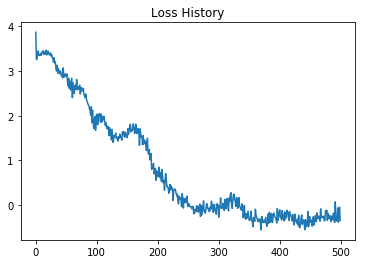

In [245]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(loss_hist[:500])
plt.title('Loss History')
plt.show()

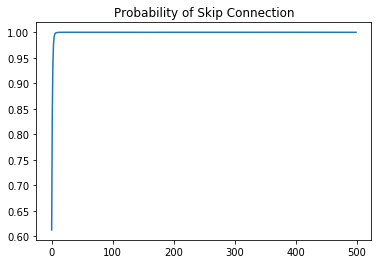

In [251]:
data = np.array(models_probs['anchor1'])[:500,]
plt.plot(data[:,0])
plt.title('Probability of Skip Connection')
plt.show()

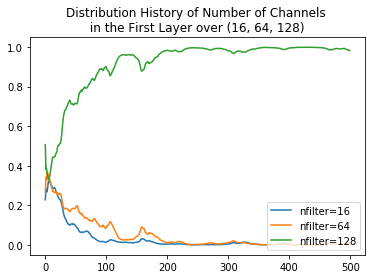

In [244]:
data = np.array(models_probs['nfilter_0'])[:500]
labels = ['nfilter=16', 'nfilter=64', 'nfilter=128']
title = 'Distribution History of Number of Channels \n in the First Layer over (16, 64, 128) '
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = plt.plot(data[:,0], label=labels[0])
line2, = plt.plot(data[:,1], label=labels[1])
line3, = plt.plot(data[:,2], label=labels[2])
plt.legend(loc='lower right')
plt.title(title)
plt.show()

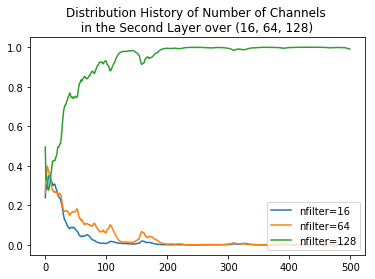

In [243]:
data = np.array(models_probs['nfilter_1'])[:500,]
labels = ['nfilter=16', 'nfilter=64', 'nfilter=128']
title = 'Distribution History of Number of Channels \n in the Second Layer over (16, 64, 128) '
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = plt.plot(data[:,0], label=labels[0])
line2, = plt.plot(data[:,1], label=labels[1])
line3, = plt.plot(data[:,2], label=labels[2])
plt.legend(loc='lower right')
plt.title(title)
plt.show()

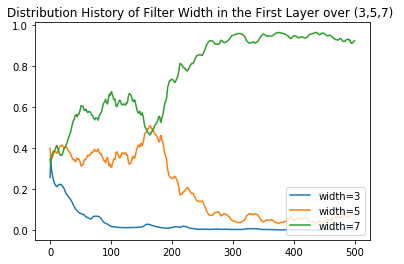

In [252]:
data = np.array(models_probs['width_0'])[:500,]
labels = ['width=3', 'width=5', 'width=7']
title = 'Distribution History of Filter Width in the First Layer over (3,5,7) '
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = plt.plot(data[:,0], label=labels[0])
line2, = plt.plot(data[:,1], label=labels[1])
line3, = plt.plot(data[:,2], label=labels[2])
plt.legend(loc='lower right')
plt.title(title)
plt.show()

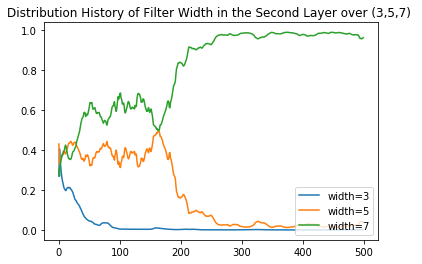

In [253]:
data = np.array(models_probs['width_1'])[:500,]
labels = ['width=3', 'width=5', 'width=7']
title = 'Distribution History of Filter Width in the Second Layer over (3,5,7) '
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = plt.plot(data[:,0], label=labels[0])
line2, = plt.plot(data[:,1], label=labels[1])
line3, = plt.plot(data[:,2], label=labels[2])
plt.legend(loc='lower right')
plt.title(title)
plt.show()

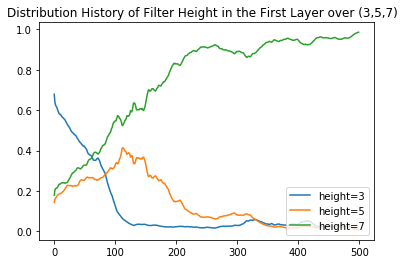

In [254]:
data = np.array(models_probs['height_0'])[:500,]
labels = ['height=3', 'height=5', 'height=7']
title = 'Distribution History of Filter Height in the First Layer over (3,5,7)  '
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = plt.plot(data[:,0], label=labels[0])
line2, = plt.plot(data[:,1], label=labels[1])
line3, = plt.plot(data[:,2], label=labels[2])
plt.legend(loc='lower right')
plt.title(title)
plt.show()

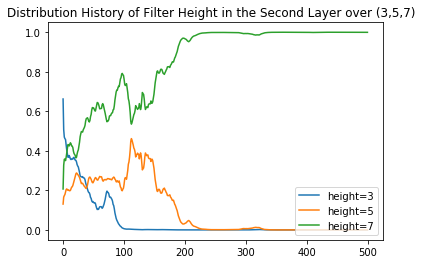

In [255]:
data = np.array(models_probs['height_1'])[:500]
labels = ['height=3', 'height=5', 'height=7']
title = 'Distribution History of Filter Height in the Second Layer over (3,5,7)  '
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = plt.plot(data[:,0], label=labels[0])
line2, = plt.plot(data[:,1], label=labels[1])
line3, = plt.plot(data[:,2], label=labels[2])
plt.legend(loc='lower right')
plt.title(title)
plt.show()